# Parsing first type files

You can find exapmles of files [here](./Test%20docs/Summary%204SА%20Malynskiy%20lishosp%20APK%202021%20EN.pdf).

Also you can download files from the [link](https://info.fsc.org/certificate.php). 
1. Select an item `Certificate Holder Login`. 
2. Select `Country or Area`: **Ukraine**
3. Select `Certificate Code` midle field `FM/COC`. You have to choose `FC` in the first field for first type documents.

The main objective is pdf documents parsing (docuemts have the same structure), getting tables with information from there. And after that, compiling a csv file with the converted information. Ultimately, a program, that will independently process files of this type and compile the resulting table, will be created.

## Preparing

In [1]:
import camelot # библиотека для извлечения таблиц
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
file = 'Test docs/Summary 4SА Malynskiy lishosp APK 2021 EN.pdf'

## Computing Document Characteristics


###Let's calculate the size of the document
This is not a very fast operation. I think that the sizes of documents will be the same for all documents of this type.

By the size of the document, I mean its maximum coordinates.

The point with coordinates $(0,0)$ is in the lower left corner, and the point with the maximum coordinates is in the upper right corner. You can read about it [here](https://www.pdfscripting.com/public/PDF-Page-Coordinates.cfm).

**However** the camelot library has its own peculiarities. There, first comes the upper left corner, and then the lower right corner to indicate the table area.
>`table_areas` accepts strings of the form x1,y1,x2,y2 where (x1, y1) -> top-left and (x2, y2) -> bottom-right in PDF coordinate space. In PDF coordinate space, the bottom-left corner of the page is the origin, with coordinates (0, 0).

In [3]:
from camelot import utils
layout, dim = utils.get_page_layout(file)
layout, dim

(<LTPage(27) 0.000,0.000,595.320,841.920 rotate=0>, (595.32, 841.92))

As you can see, this document has 27 pages. Its maximum coordinates are approximately $(600, 840)$

### List of required pages and coordinates of the beginning and end of the tables.

The pdf is large and has a lot of tables. We don't need all the tables. Therefore, we need to find the page and coordinates from which the tables we need begin and the page and coordinates where the tables we need end (the necessary tables go sequentially, there are no unnecessary tables between them).


To solve this problem, we will use [pdfminer.six](https://github.com/pdfminer/pdfminer.six). The solution to this problem was stated [here](https://stackoverflow.com/questions/22898145/how-to-extract-text-and-text-coordinates-from-a-pdf-file).

In [4]:
from pdfminer.pdfparser import PDFParser
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfpage import PDFTextExtractionNotAllowed
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.pdfdevice import PDFDevice
from pdfminer.layout import LAParams
from pdfminer.converter import PDFPageAggregator
import pdfminer
from pdfminer.pdfinterp import resolve1

In [5]:
def get_optional_text(o) -> str:
    """Text of LTItem if available, otherwise empty string"""
    if hasattr(o, 'get_text'):
        return o.get_text().strip()
    return ''

A similar function for checking text was chosen because objects in a pdf file may contain more text than specified in `target_text`.

In [6]:
def check_text_for_marker(target_text: str, object_text: str) -> bool:
    """
    function check text and if 
    target text is in object text return true
    else false

    target text is text that indicate start or end of desired area
    """
    if target_text in object_text:
        return True
    else:
        return False

##### Specify the start and end marks of the tables we need.

The label is the page number and the y-coordinate ($y$)

In [108]:
start_text = '5.4.2. Minor condition'
end_text = 'CHAIN OF CUSTODY'

# Начальные значения мы их будем уточнять
start_page = 0
start_coord = 0
end_page = 0
end_coord = 0


In [8]:
with  open(file, 'rb') as fp:

    # Create a PDF parser object associated with the file object.
    parser = PDFParser(fp)

    # Create a PDF document object that stores the document structure.
    # Password for initialization as 2nd parameter
    document = PDFDocument(parser)

    # Check if the document allows text extraction. If not, abort.
    if not document.is_extractable:
        raise PDFTextExtractionNotAllowed

    # Create a PDF resource manager object that stores shared resources.
    rsrcmgr = PDFResourceManager()

    # Create a PDF device object.
    device = PDFDevice(rsrcmgr)

    # BEGIN LAYOUT ANALYSIS
    # Set parameters for analysis.
    laparams = LAParams()

    # Create a PDF page aggregator object.
    device = PDFPageAggregator(rsrcmgr, laparams=laparams)

    # Create a PDF interpreter object.
    interpreter = PDFPageInterpreter(rsrcmgr, device)

    # loop over all pages in the document
    num_page =0 
    for page in PDFPage.create_pages(document):
        num_page +=1
        # read the page into a layout object
        interpreter.process_page(page)
        layout = device.get_result()

        # loop over all objects in current page
        for obj in layout._objs:
            obj_text = get_optional_text(obj)
            if check_text_for_marker(start_text, get_optional_text(obj)):
                print(obj_text)
                print(''.join(f'{int(i)} ' for i in obj.bbox))
                print(num_page)

5.4.2. Minor conditions 
Minor conditions 31 (Mn-31)
56 597 208 640 
19


As a result, we got the text of the object from which we have to start looking for tables, its coordinates (lower left and upper right corners) and page number.

As you can see in this example, our start mark includes extra text (it is inside the table). Therefore, you need to take the upper coordinate in $y$.

In [116]:
def start_and_end_coords_pages(file_path: str) -> tuple:
    start_page = 0
    start_coord = 0
    end_page = 0
    end_coord = 0
    with  open(file_path, 'rb') as fp:

        # Create a PDF parser object associated with the file object.
        parser = PDFParser(fp)

        # Create a PDF document object that stores the document structure.
        # Password for initialization as 2nd parameter
        document = PDFDocument(parser)

        # Check if the document allows text extraction. If not, abort.
        if not document.is_extractable:
            raise PDFTextExtractionNotAllowed

        # Create a PDF resource manager object that stores shared resources.
        rsrcmgr = PDFResourceManager()

        # Create a PDF device object.
        device = PDFDevice(rsrcmgr)

        # BEGIN LAYOUT ANALYSIS
        # Set parameters for analysis.
        laparams = LAParams()

        # Create a PDF page aggregator object.
        device = PDFPageAggregator(rsrcmgr, laparams=laparams)

        # Create a PDF interpreter object.
        interpreter = PDFPageInterpreter(rsrcmgr, device)

        # loop over all pages in the document
        num_page =0 
        for page in PDFPage.create_pages(document):
            num_page +=1
            # read the page into a layout object
            
            interpreter.process_page(page)
            layout = device.get_result()

            # loop over all objects in current page
            for obj in layout._objs:
                obj_text = get_optional_text(obj)
                if check_text_for_marker(start_text, get_optional_text(obj)):
                    start_page = num_page
                    start_coord = obj.bbox[1]
#                     print(get_optional_text(obj))
                if check_text_for_marker(end_text, get_optional_text(obj)):
                    end_page = num_page
                    end_coord = obj.bbox[1]
    return (start_page, start_coord), (end_page, end_coord)

In [10]:
_pages_coords =  start_and_end_coords_pages(file)
start_page, start_coord = _pages_coords[0]
end_page, end_coord = _pages_coords[1]
start_page, start_coord, end_page, end_coord

(19, 597.268, 26, 530.398)

In [117]:
_pages_coords =  start_and_end_coords_pages('Test docs/' + file_names[0])
start_page, start_coord = _pages_coords[0]
end_page, end_coord = _pages_coords[1]
start_page, start_coord, end_page, end_coord

(19, 248.29160000000002, 20, 385.7116)

### Getting the top and bottom of the page

We only need tables, we don't need headers or footers or page numbers. So I decided to just take one page and extract the tables from it. Table borders will be the top and bottom of the page

In [11]:
tables = camelot.read_pdf(file, pages = '20', )
tables

<TableList n=2>

/tmp/ipykernel_181437/3822059128.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  _p.show()


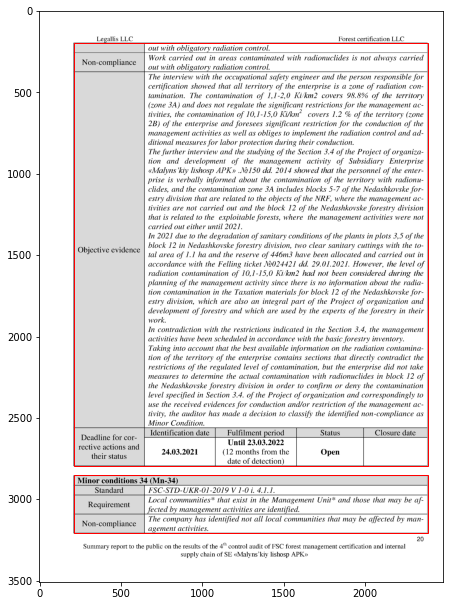

In [12]:
_p = camelot.plot(tables[0], kind='contour')
_p.set_size_inches(18.5, 10.5)
_p.show()


In [13]:
top_page  = round(tables[0].cells[0][0].y2,0)
bottom_page = round(tables[-1].cells[-1][-1].y1, 0)

# Для удобства еще запишем глобальные переменные (чтобы узнавать, что это глобальные переменные)
TOP_PAGE, BOTTOM_PAGE = top_page, bottom_page 
top_page, bottom_page

(795.0, 72.0)

## Extract tables

When you extract tables, you may encounter the following difficulties

- Breaking the table by pages (the first part of the table on one page, the second on the next)
- Not always camelot recognizes the table.

In order to solve these issues, it is necessary to solve and consider such problems
- determination of the completeness of the table:
  - number of columns
  - number of rows
  - the presence of the main attributes:
    - header `'Minor condition'`
    - field ``Standard'`
    - field `'Deadline for cor-\nrective actions and \ntheir status'`
    - field `'Identification date'`
- If the table is not complete, then this is the top of the table or its bottom:
  - For the top of the table find out:
    - header `'Minor condition'`
    - field `'Standard'` **Not sure**.
    - Determine if the last row of the table has a title, or is it just text.
  - For the bottom of the table find out:
    - field `'Deadline for cor-\nrective actions and \ntheir status'`
    - field `'Identification date'`
    - Determine if the first row of the table has a heading, or is it just text.
- Table top or bottom (its edge is near the top/bottom of the page)
  - The top border of the table is near the top of the page (not higher on eps1 and not lower on eps2)
  - The bottom border of the table is near the bottom of the page (not higher on eps1 and not lower on eps2)
- Merge broken tables
  - recognize that the first table is incomplete and **not lower**, and the second is incomplete and lower.
  - Determine if the last and first rows of the corresponding tables have attributes
  - Insert empty columns in the top table (bring to the correct size by columns)
  - connect tables.
    - If there is no attribute at the top, then the text is glued to the attribute of the bottom
    - If there is no attribute at the bottom, then the text is glued to the attribute of the top
    - If both tables do not have an attribute, then this is an error.
- Recognition of unrecognized tables. I believe these are the tops of the tables that have been cut off by the page. To solve this, the last paragraph will help us, if the previous table is not at the bottom, and the next table is incomplete (bottom of the table), then we missed the top of the table.
  - Check if there is an unrecognized table. Behind a table that is not at the bottom (there is room to the bottom of the page) and **bottom** is an incomplete bottom table. This means that we skipped a small table, the beginning of the second table.
  - Determine the area of the unrecognized table
  - Recognize it using the `stream` algorithm
  - As practice has shown, small tables in which the text occupies only one line are not recognized. However, if the text opposite the attribute spans more lines, then the lines are not recognized correctly. Therefore, it will be necessary to translate the recognized table into a decent form (gluing lines)
    - determine the number of arguments and the number of lines of text.
    - If the argument is opposite the text and there is another argument in the line above it, then this is all good. This means that for this argument, the text was recognized as a single line.
    - **Don't do it yet** If there are empty arguments above the argument, then the text in these lines belongs to the argument. We will also assume that the text is recognized symmetrically. Therefore, let's see how many lines of text above the argument belong to it and then assign the same number of lines of text under the argument to this argument. **Questionable**

### Determining the completeness of a table

In [14]:
tables = camelot.read_pdf(file, pages = '19')
tables


<TableList n=1>

/tmp/ipykernel_181437/1382988782.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  _p.show()


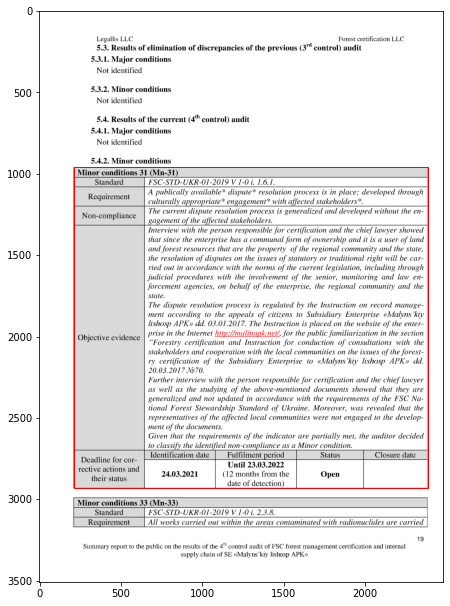

In [15]:
_p = camelot.plot(tables[0], kind='contour')
_p.set_size_inches(18.5, 10.5)
_p.show()

We see a complete table here, and we will take it as an example.

In [16]:
tables[0].df

,0,1,2,3,4
0,Minor conditions 31 (Mn-31),,,,
1,Standard,FSC-STD-UKR-01-2019 V 1-0 i. 1.6.1.,,,
2,Requirement,A publically available* dispute* resolution pr...,,,
3,Non-compliance,The current dispute resolution process is gene...,,,
4,Objective evidence,Interview with the person responsible for cert...,,,
5,Deadline for cor-\nrective actions and \ntheir...,Identification date,Fulfilment period,Status,Closure date
6,,24.03.2021,Until 23.03.2022 \n(12 months from the \ndate ...,Open,


In [17]:
# размер полной таблицы
tables[0].df.shape

(7, 5)

In [18]:
def check_shape(df)-> bool:
    '''
        Check shape of table (dataframe)
    '''
    return df.shape == (7,5)

In [19]:
check_shape(tables[0].df)

True

In [130]:
TITLE = 'Minor condition'

def check_title(df)-> bool:
    """
    Check if title is in our table (dataframe)
    """
    return TITLE in df[0][0]

In [21]:
check_title(tables[0].df)

True

In [132]:
# атрибуты верха таблицы
TOP_ATTR = ['Standard']
# атрибуты низа таблицы
BOTTOM_ATTR = ['Deadline for cor-\nrective actions and \ntheir status', 'Identification date']
# главные атрибуты таблицы
MAIN_ATTR = TOP_ATTR + BOTTOM_ATTR

def check_attributes(df, attr: list)-> bool:
    """
    Check that table (dataframe) has all attributes from list attr
    function check only that table has this attrubutes, don't check their places
    """
    res = []
    for _attr in attr:
        res.append((df == _attr).values.sum())

    return np.all(np.array(res))      


In [133]:
check_attributes(tables[0].df, MAIN_ATTR)

False

In [24]:
def is_full_table(df) -> bool:
    """
    Check that table is full.
    """
    return check_shape(df) and \
        check_title(df) and \
        check_attributes(df, MAIN_ATTR)

In [25]:
is_full_table(tables[0].df)

True

### If the table is not full, then this is the top of the table or its bottom

In [26]:
def is_top_table(df)-> bool:
    """
    Check that table has top attributes and title
    """
    return check_title(df) and\
         check_attributes(df, TOP_ATTR)

In [27]:
is_top_table(tables[0].df)

True

In [28]:
def table_has_last_attribute(df)-> bool:
    """
    Check that table in last row has attribute (zero column), not only text
    """
    shape = df.shape
    return bool(df[0][shape[0]-1])

As you can see, the full table does not have the last attribute, but this is normal. We will not check full tables for the last attribute. This check is needed only for incomplete tables that need to be joined with their rest part on another page.

In [29]:
table_has_last_attribute(tables[0].df)

False

In [30]:
def is_bottom_table(df)-> bool:
    """
    Check that table has bottom attributes
    """
    return check_attributes(df, BOTTOM_ATTR)

In [31]:
is_bottom_table(tables[0].df)

True

In [32]:
def table_has_first_attribute(df)-> bool:
    """
    Check that table in first row has attribute (zero column), not only text
    """
    # shape = df.shape
    return bool(df[0][0])

In [33]:
table_has_first_attribute(tables[0].df)

True

### Table top or bottom (its edge is near the top/bottom of the page)
- The top border of the table is near the top of the page (not higher on eps1 and not lower on eps2)
- The bottom border of the table is near the bottom of the page (not higher on eps1 and not lower on eps2)

In [34]:
# Верхняя граница таблицы находится рядом с верхом страницы (не выше на eps1 и не ниже на eps2)
def check_top_table(table, eps1 = 3 ,eps2 = 10) ->bool:
    """
    Check that top of the table is in boundaries
    """

    top_table = table.cells[0][0].y2
    return  top_page - eps2 < top_table < top_page + eps1

In [35]:
check_top_table(tables[0])

False

In [36]:
# Нижняя граница таблицы находится рядом с низом страницы (не выше на eps1 и не ниже на eps2)
def check_bottom_table(table, eps1 = 15 ,eps2 = 3) ->bool:
    """
    Check that bottom of the table is in boundaries
    """

    top_table = table.cells[-1][-1].y1
    return  bottom_page - eps2 < top_table < bottom_page + eps1

In [37]:
check_bottom_table(tables[0])

False

### Merge broken tables
   - recognize that the first table is incomplete and **not lower**, and the second is incomplete and lower.
   - Determine if the last and first rows of the corresponding tables have attributes
   - Insert empty columns in the top table (bring to the correct size by columns)
   - connect tables.
     - If there is no attribute at the top, then the text is glued to the attribute of the bottom
     - If there is no attribute at the bottom, then the text is glued to the attribute of the top
     - If both tables do not have an attribute, then this is an error.

Let's load tables of 2 pages and, using their example, we will try to glue the tables together.

In [38]:
tables = camelot.read_pdf(file, pages = '21,22')
# tables = camelot.read_pdf(file, pages = '24,25')
tables

<TableList n=5>

/tmp/ipykernel_181437/1382988782.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  _p.show()


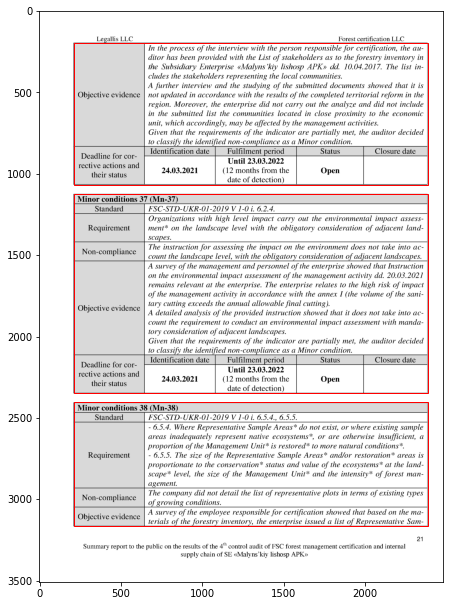

In [39]:
_p = camelot.plot(tables[0], kind='contour')
_p.set_size_inches(18.5, 10.5)
_p.show()

/tmp/ipykernel_181437/1675524868.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  _p.show()


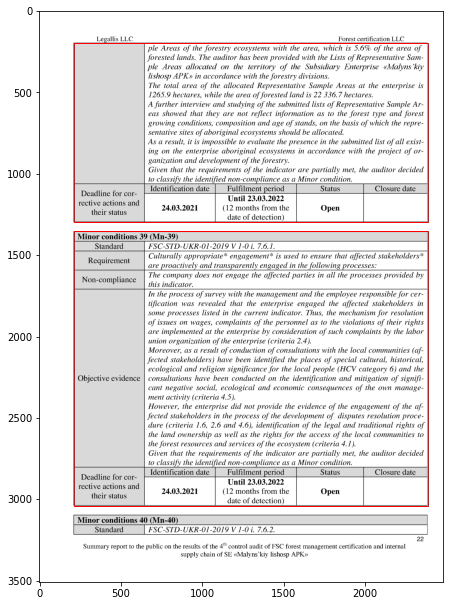

In [40]:
_p = camelot.plot(tables[3], kind='contour')
_p.set_size_inches(18.5, 10.5)
_p.show()

In [41]:
df1 = tables[2].df
df1

,0,1
0,Minor conditions 38 (Mn-38),
1,Standard,"FSC-STD-UKR-01-2019 V 1-0 i. 6.5.4., 6.5.5."
2,Requirement,- 6.5.4. Where Representative Sample Areas* do...
3,Non-compliance,The company did not detail the list of represe...
4,Objective evidence,A survey of the employee responsible for certi...


In [42]:
df2 = tables[3].df
df2

,0,1,2,3,4
0,,ple Areas of the forestry ecosystems wit...,,,
1,Deadline for cor-\nrective actions and \ntheir...,Identification date,Fulfilment period,Status,Closure date
2,,24.03.2021,Until 23.03.2022 \n(12 months from the \ndate ...,Open,


In [43]:
(not is_full_table(df1)) and not is_bottom_table(df1)

True

In [44]:
(not is_full_table(df2)) and is_bottom_table(df2)

True

As you can see `df1` is the top of the table, `df2` is the bottom

Let's write a table join function

In [45]:
def concat_tables(df_top, df_bottom):
    """
    Concatenate tables, or 
    raise VAlueError if both tables don't have attribute
    """
    if table_has_last_attribute(df_top):
        if table_has_first_attribute(df_bottom):
            # соединение если обе таблицы имеют атрибуты
            # разрыв страницы не разорвал ячейку таблицы
            return pd.concat([df_top, df_bottom],ignore_index= True).fillna('')
        else:
            # нет атрибута у нижней таблицы
            last_row = df_top.shape[0]-1
            new_text = df_top[1][last_row] + df_bottom[1][0]
            df_bottom = df_bottom.drop(0)
            
            res = pd.concat([df_top, df_bottom],ignore_index= True).fillna('')
            res[1][last_row] = new_text
            return res
    else:
        if table_has_first_attribute(df_bottom):
            # нет атрибута у верхней таблицы
            last_row = df_top.shape[0]-1
            new_text =  df_top[1][last_row] + df_bottom[1][0]
            df_top = df_top.drop(last_row)
            
            res = pd.concat([df_top, df_bottom],ignore_index= True).fillna('')
            res[1][last_row] = new_text
            return res

        else:
            raise ValueError("Both tables don't have attribute")

In [46]:
_df = concat_tables(df1,df2)
_df

,0,1,2,3,4
0,Minor conditions 38 (Mn-38),,,,
1,Standard,"FSC-STD-UKR-01-2019 V 1-0 i. 6.5.4., 6.5.5.",,,
2,Requirement,- 6.5.4. Where Representative Sample Areas* do...,,,
3,Non-compliance,The company did not detail the list of represe...,,,
4,Objective evidence,A survey of the employee responsible for certi...,,,
5,Deadline for cor-\nrective actions and \ntheir...,Identification date,Fulfilment period,Status,Closure date
6,,24.03.2021,Until 23.03.2022 \n(12 months from the \ndate ...,Open,


In [47]:
_df[1][4]

'A survey of the employee responsible for certification showed that based on the ma-\nterials of the forestry inventory, the enterprise issued a list of Representative Sam-ple  Areas  of  the  forestry  ecosystems  with  the  area,  which  is  5.6%  of  the  area  of \nforested lands. The auditor has been provided with the Lists of Representative Sam-\nple  Areas  allocated  on \nthe \nterritory  of \nthe  Subsidiary  Enterprise  «Malyns’kiy \nlishosp APK» in accordance with the forestry divisions. \nThe  total  area  of  the  allocated  Representative  Sample  Areas  at  the  enterprise  is \n1265.9 hectares, while the area of forested land is 22 336.7 hectares. \nA further interview and studying of the submitted lists of Representative Sample Ar-\neas  showed  that  they  are  not  reflect  information  as  to  the  forest  type  and  forest \ngrowing conditions, composition and age of stands, on the basis of which the repre-\nsentative sites of aboriginal ecosystems should be alloca

In [48]:
_df[1][4] == df1[1][4] + df2[1][0]

True

### Recognition of unrecognized tables.

I believe these are the tops of the tables that have been cut off by the page. To solve this, the last paragraph will help us, if the previous table is not at the bottom, and the next table is incomplete (bottom of the table), then we missed the top of the table.
  - Check if there is an unrecognized table. Behind a table that is not at the bottom (there is room to the bottom of the page) and **bottom** is an incomplete bottom table. This means that we skipped a small table, the beginning of the second table.
  - Determine the area of ​​the unrecognized table
  - Recognize it using the `stream` algorithm
  - As practice has shown, small tables in which the text occupies only one line are not recognized. However, if the text opposite the attribute spans more lines, then the lines are not recognized correctly. Therefore, it will be necessary to translate the recognized table into a decent form (gluing lines)
    - determine the number of arguments and the number of lines of text.
    - If the argument is opposite the text and there is another argument in the line above it, then this is all good. This means that for this argument, the text was recognized as a single line.
    - **Don't do it yet** If there are empty arguments above the argument, then the text in these lines belongs to the argument. We will also assume that the text is recognized symmetrically. Therefore, let's see how many lines of text above the argument belong to it and then assign the same number of lines of text under the argument to this argument. **Questionable**

In [49]:
tables = camelot.read_pdf(file, pages='19,20')
tables

<TableList n=3>

/tmp/ipykernel_181437/1382988782.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  _p.show()


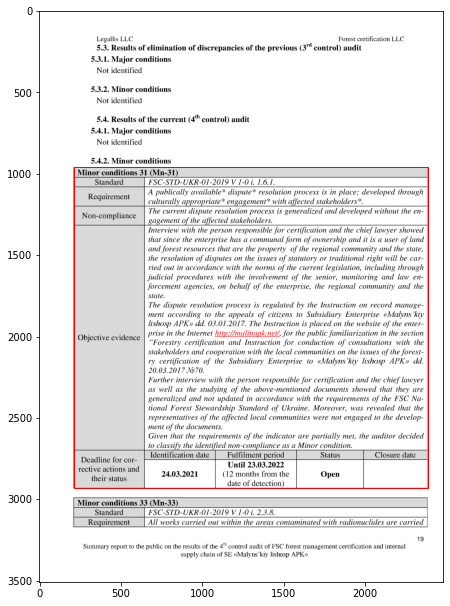

In [50]:
_p = camelot.plot(tables[0], kind='contour')
_p.set_size_inches(18.5, 10.5)
_p.show()

/tmp/ipykernel_181437/4040054674.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  _p.show()


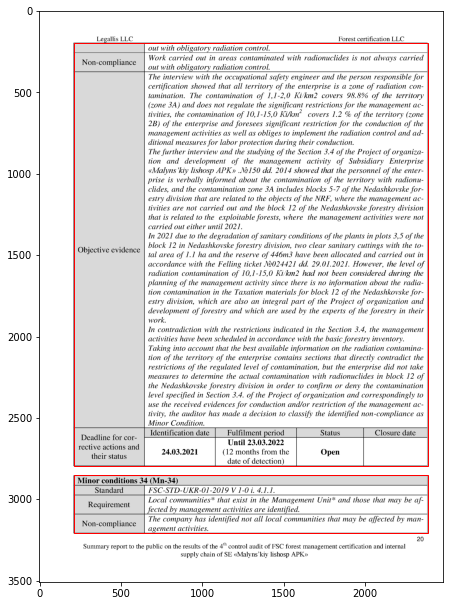

In [51]:
_p = camelot.plot(tables[2], kind='contour')
_p.set_size_inches(18.5, 10.5)
_p.show()

As you can see in the examples given, a small part of the table is not recognized. Let's recognize it.

In [52]:
def find_unrecognized_table_between_two_another (table1, table2) -> list:
    """
    check tables and if between they can exist another table function return table area
    or return empty str
    """
    res =''
    if (not check_bottom_table(table1)) and is_bottom_table(table1.df) and ((not is_full_table(table2.df)) and is_bottom_table(table2.df)):
        res = [0, int(table1.cells[-1][-1].y1), int(table1.cells[-1][-1].x2), int(bottom_page)]
        res = ','.join([str(i) for i in res])
    return res


In [53]:
table_area = find_unrecognized_table_between_two_another(tables[0], tables[1])
table_area

'0,138,572,72'

In [54]:
table_area = str(table_area)
table_area

'0,138,572,72'

In [55]:
test_table = camelot.read_pdf(file, pages = '19', table_areas=[table_area], flavor='stream')
test_table

<TableList n=1>

/tmp/ipykernel_181437/3494153209.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  camelot.plot(test_table[0], kind='contour').show()
/tmp/ipykernel_181437/3494153209.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  _p.show()


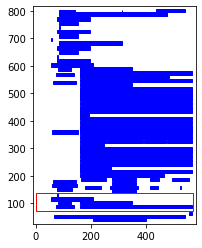

In [56]:
camelot.plot(test_table[0], kind='contour').show()
_p.set_size_inches(18.5, 10.5)
_p.show()

In [57]:
test_table[0].df

,0,1
0,Minor conditions 33 (Mn-33),
1,Standard,FSC-STD-UKR-01-2019 V 1-0 i. 2.3.8.
2,Requirement,All works carried out within the areas contami...


# Function to extract tables from a file

Let's collect all the previously recorded ideas into one test function.

<!-- Let's proceed in this way.
- Loop through all pages with tables
- At a time, we look at 2 full pages at once. This is necessary in order to determine whether there are unrecognized tables and glue the broken ones.
- If this is the first or last page, then we will check the first \ last table to determine that they do not go beyond the coordinate boundary. We will throw out the extra ones (those that are abroad) until we get a good one.
- We go through the tables from two pages, if we see that the next table is located at the top of the table, then this is the end of the first page. In this case, we look to see if there are broken or unrecognized tables. If they are, then we recognize, glue and mark with a flag that at the next iteration we will ignore the first table. **We will keep tables only from the first page (+ the end of the torn one)** -->

We will act according to this algorithm.
1. We scan all the pages of the document, which should contain the tables we need. The result is a list of tables.
1. Next, we will extract the tables (which are found on the first page) of their list starting from the first, if their end is located above the coordinates of the beginning of the tables on the first page
1. Now we remove the tables (which are found on the last page) from the end of the list if their beginning is lower than the coordinates of the end of the tables on the last page
1. Now we will iterate over the list of remaining tables.
    1. If the current table is full and the next table is the bottom one on a new page, then we have not recognized the table. We calculate the area of ​​the unrecognized table and its page. We are trying to recognize the table using `stream`. After that, we insert the recognized table into the list of tables, behind the current full table.
    1. Check the current table for completeness, if it is complete, then write it to the list of final tables
    
    1. If the current table is not full, but the top one, then we look at the next table, if it is the bottom one and on top of the page (on the next one), then this is the end of the current table, join the tables, throw them out of the list of considered ones (shift the pointer), write the combined table to the list of final tables. If the next table is not the bottom one on the new page, then throw an exception.
    1. If the current table is lower, then we throw an exception. Well, or in any other cases.

In [124]:
def test_func(file_path):
    _pages_coords =  start_and_end_coords_pages(file_path)
    start_page, start_coord = _pages_coords[0]
    end_page, end_coord = _pages_coords[1]
    print(start_page, start_coord, end_page, end_coord)
    
    pages = f'{start_page}-{end_page}'
    print(pages)
    
    res_df = []
    
    # считываем все таблицы
    tables = list(camelot.read_pdf(file_path, pages = pages))
    print(len(tables))
    
    # убираем лишние таблицы из начала
    while len(tables) > 0 and tables[0].cells[-1][-1].y1 > start_coord and tables[0].page == start_page:
        tables.pop(0)
    print(f'after pop (0) {len(tables)}')
    # убираем лишние таблицы из конца
    while len(tables) > 0 and tables[-1].cells[0][0].y2 < end_coord and tables[-1].page == end_page:
        tables.pop(-1)
    print(f'after pop (-1) {len(tables)}')
    # итерируемся по списку таблиц
    index = 0
    while index < len(tables):
        N = len(tables)
        cur_table = tables[index]
        next_table = None
        if index < len(tables):
            print(len(tables), index)
            next_table = tables[index+1]       
        
        if is_full_table(cur_table.df) and index != N and not is_full_table(next_table.df) and is_bottom_table(next_table.df) and cur_table.page+1 == next_table.page:
            # пропустили кусок таблицы
            # нужно распознать нераспознанную таблицу и вставить ее в список таблиц
            table_area = find_unrecognized_table_between_two_another(cur_table, next_table)
            table_area = str(table_area)
            unrecog_table = camelot.read_pdf(file_path, pages = f'{cur_table.page}', table_areas=[table_area], flavor='stream')
            
            unrecog_table = list(unrecog_table)
            print(f'{unrecog_table=}')
            if len(unrecog_table) != 0:
                tables = tables[:index+1] + unrecog_table + tables[index+1:]
            
            next_table = None
            if index < len(tables):
                print(len(tables), index)
                next_table = tables[index+1]  
            
#         print(index, is_full_table(cur_table.df))
#         _p = camelot.plot(cur_table, kind='contour')
#         _p.set_size_inches(18.5, 10.5)
#         _p.show()
        
        print(index, is_full_table(cur_table.df))
        if is_full_table(cur_table.df):
            res_df.append(cur_table.df)
        elif is_top_table(cur_table.df) and index != N and not is_full_table(next_table.df) and is_bottom_table(next_table.df) and cur_table.page+1 == next_table.page:
            new_df = concat_tables(cur_table.df, next_table.df)
            res_df.append(new_df)
            index +=1
        else:
            raise ValueError('Something has gone wrong')
        
        index +=1
        
    return res_df
        
    

In [59]:
_df = test_func(file)

19
18 0
unrecog_table=[<Table shape=(3, 2)>]
19 0
19 1
19 3
19 5
19 6
19 8
unrecog_table=[<Table shape=(2, 2)>]
20 8
20 9
20 11
20 12
20 14
20 15
20 17
20 18


In [60]:
len(_df)

13

In [61]:
!ls ./"Test docs"

'Summary 3SA_Baranivka FHSE 2019 EN.pdf'
'Summary 3SA with D-A Popelnya Forestry  2019 ENG.pdf'
'Summary 4SА Malynskiy lishosp APK 2021 EN.pdf'
'Summary RA FM GP Emilchinskoe LH 2021 EN.pdf'


In [102]:
file_names = [
    'Summary 3SA_Baranivka FHSE 2019 EN.pdf',
    'Summary 3SA with D-A Popelnya Forestry  2019 ENG.pdf',
    'Summary 4SА Malynskiy lishosp APK 2021 EN.pdf',
    'Summary RA FM GP Emilchinskoe LH 2021 EN.pdf',
    ]

In [131]:
for file_name in file_names[1:]:
    path = "Test docs/" + file_name
    
    print(file_name)
    _df = test_func(path)
    print(f'{file_name=} have {len(_df)} tables')

Summary 3SA with D-A Popelnya Forestry  2019 ENG.pdf
20 733.1416 20 165.2216
20-20
3
after pop (0) 3
after pop (-1) 2
2 0
0 False


ValueError: Something has gone wrong

In [126]:
tables = camelot.read_pdf( "Test docs/" + file_names[1], pages = '20')

In [129]:
is_full_table(tables[0].df)

False

/tmp/ipykernel_181437/2878550523.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  _p.show()


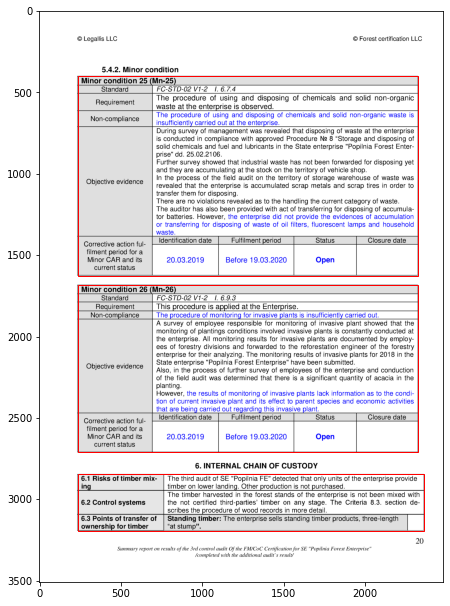

In [127]:
_p = camelot.plot(tables[-1], kind='contour')
_p.set_size_inches(18.5, 10.5)
_p.show()

In [67]:
new_file = "Test docs/" + file_names[-1]

In [69]:
new_file

'Test docs/Summary RA FM GP Emilchinskoe LH 2021 EN.pdf'

In [101]:
_df = test_func(new_file)

20 610.488 28 264.938
20-28
23
after pop (0) 23
after pop (-1) 22
22 0
22 1
22 3


ValueError: Something has gone wrong

In [85]:
tables = camelot.read_pdf(new_file, pages = '20')

In [86]:
is_full_table(tables[0].df)

True

/tmp/ipykernel_181437/1382988782.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  _p.show()


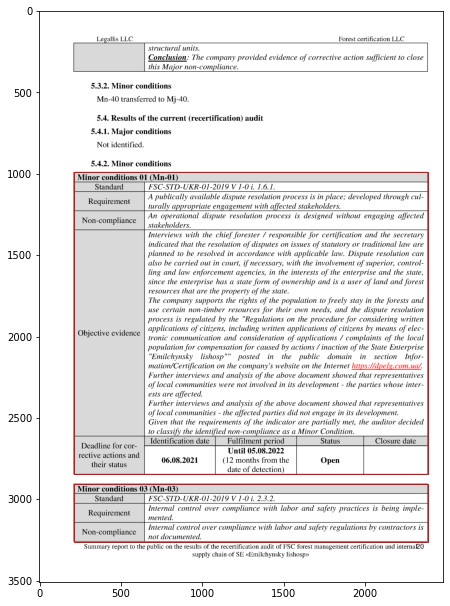

In [87]:
_p = camelot.plot(tables[0], kind='contour')
_p.set_size_inches(18.5, 10.5)
_p.show()

## Tested different files, found many errors

1. If you look closely, you may find that the names of the fields in the tables are different.
    - For example, `Minor condition` is sometimes put there or not put at the end of `s`. This applies to both the section header and the table header.
    - The title of section 6 is also different. I've just taken the last part of the phrase `CHAIN OF CUSTODY` so far, it works.
    - I also found a difference in the name of one of the lower attributes (last line, first column).
2. The table can be cut along the line that separates the `indefication date` from the date itself. So this cuts the cell with the name of the last attribute. Also, the standard method does not find such tables. Also, sometimes a part of the table (one text line) is simply cut off, which, of course, is also not recognized.
